# Menu <a class="anchor" id="menu"></a>

* [1. Préparatifs pour les algorithmes non-supervisés](#setup)

# Le data-drift

**TODO**

---
# Préparatifs 

In [1]:
import os
# import re
# import time
# import math
# import string
import datetime
# import unicodedata
# import json
from zipfile import ZipFile
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

random_seed = 0
np.random.seed(random_seed)
cmap_ref = 'nipy_spectral'

# import gc
# gc.enable()

In [2]:
def load_from_zip(csv_name):
    return pd.read_csv(ZipFile(os.path.join("data", f"{csv_name}.zip")).open(csv_name))


# data_geo = load_from_zip("olist_geolocation_dataset.csv")
# data_geo = pd.read_csv(os.path.join('data',"olist_geolocation_dataset_clean.csv"))

# data_customer = load_from_zip("olist_customers_dataset_clean.csv")
data_customer = pd.read_csv(os.path.join('data', "olist_customers_dataset_clean.csv"))

# data_orders = load_from_zip("olist_orders_dataset.csv")
data_orders = pd.read_csv(os.path.join('data', "olist_orders_dataset_clean.csv"))

# data_items = load_from_zip("olist_order_items_dataset.csv")
data_items = pd.read_csv(os.path.join('data', "olist_order_items_dataset_clean.csv"))

# data_products = load_from_zip("olist_products_dataset.csv")
# data_products = pd.read_csv(os.path.join('data',"olist_products_dataset_clean.csv"))

# data_payments = load_from_zip("olist_order_payments_dataset.csv")
data_payments = pd.read_csv(os.path.join('data', "olist_order_payments_dataset_clean.csv"))

# data_reviews = load_from_zip("olist_order_reviews_dataset.csv")
data_reviews = pd.read_csv(os.path.join('data', "olist_order_reviews_dataset_clean.csv"))

# data_sellers = pd.read_csv(os.path.join('data',"olist_sellers_dataset_clean.csv"))
# data_categories = pd.read_csv(os.path.join('data',"product_category_name_translation_clean.csv"))

## Préparatifs

#### D'abord on restreint la selection entre le 01/09/2017 et le 01/09/2018 pour avoir une période d'un an et on ne garde que ceux dont le processus de livraison est allé jusqu'au bout (delivered)

In [3]:
selection1 = data_orders[
    (data_orders.order_purchase_timestamp >= '2017-09-01 00:00:00') & 
    (data_orders.order_purchase_timestamp < '2018-09-01 00:00:00') & 
    (data_orders.order_status == 'delivered')][['order_id', 'customer_id', 'order_purchase_timestamp']]
selection1.head()

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39


#### Puis on associe ces commandes aux id uniques des clients qui les ont passées

In [4]:
selection2 = selection1.merge(data_customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
selection2.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6


## 1.1 Calcul de la `Récence` <a class="anchor" id="rfm_R"></a> [⇪](#menu)

#### On converti la date d'achat en nombre de jours écoulés *(depuis le moment ou l'on arrête notre selection donc le 01/09/2018)*

In [5]:
ref_date = datetime.datetime.strptime('2018-09-01 00:00:00', '%Y-%m-%d %H:%M:%S')
selection3 = selection2.copy()

selection3.order_purchase_timestamp = selection2.order_purchase_timestamp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
selection3['days_ago'] = selection3.order_purchase_timestamp - ref_date
selection3['days_ago'] = selection3.days_ago.apply(lambda x: x.days)
selection3.drop(columns=['order_purchase_timestamp'], inplace=True)
selection3.head()

,order_id,customer_id,customer_unique_id,days_ago
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,-334
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,-39
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,-24
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,-287
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,-200


In [6]:
selection3.describe().T

,count,mean,std,min,25%,50%,75%,max
days_ago,74213.0,-176.203778,99.367873,-365.0,-263.0,-176.0,-92.0,-3.0


#### Puis, on crée une **nouvelle table** `R_data` qui stoque la **recence** *(la plus petite valeur `days_ago`)* de chaque client

In [7]:
R_data = selection3[['customer_unique_id', 'days_ago']].groupby('customer_unique_id').min().reset_index()
R_data.rename(columns={'days_ago': 'recence'}, inplace=True)
R_data.head()

,customer_unique_id,recence
0,0000366f3b9a7992bf8c76cfdf3221e2,-114
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-117
2,0000f6ccb0745a6a4b88665a16c9f078,-324
3,0004aac84e0df4da2b147fca70cf8255,-291
4,0004bd2a26a76fe21f786e4fbd80607f,-149


In [8]:
R_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,72247.0,-176.54805,99.464265,-365.0,-264.0,-176.0,-92.5,-3.0


## 1.3 Calcul du `Montant` <a class="anchor" id="rfm_M"></a> [⇪](#menu)

#### On calcul le montant total de chaque commande *(puisqu'il peut y avoir plusieurs moyens de paiements)*

In [12]:
total_amount_per_order = selection3[['order_id']].merge(
        data_payments[['order_id', 'payment_value']], on='order_id', how='left'
    ).groupby('order_id').sum().reset_index()
total_amount_per_order.rename(columns={'payment_value': 'montant'}, inplace=True)
total_amount_per_order.head()

,order_id,montant
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,000229ec398224ef6ca0657da4fc703e,216.87
2,00024acbcdf0a6daa1e931b038114c75,25.78
3,00054e8431b9d7675808bcb819fb4a32,31.75
4,000576fe39319847cbb9d288c5617fa6,880.75


#### Puis, on crée une **nouvelle table** `M_data` qui stoque le **montant** *(le total des montants de toutes les commandes faites sur la période choisie)* pour chaque client

In [13]:
M_data = selection3[['customer_unique_id', 'order_id']].merge(
        total_amount_per_order, on='order_id', how='left'
    ).groupby('customer_unique_id').sum().reset_index()
M_data.head()

,customer_unique_id,montant
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,43.62
3,0004aac84e0df4da2b147fca70cf8255,196.89
4,0004bd2a26a76fe21f786e4fbd80607f,166.98


In [14]:
M_data.describe().T

,count,mean,std,min,25%,50%,75%,max
montant,72247.0,164.548839,217.050575,0.0,63.13,108.2,182.14,7274.88


## 1.4 Calcul des `scores RFM` <a class="anchor" id="rfm_scores"></a> [⇪](#menu)

#### On associe les trois jeux de données `R_data`, `F_data` et `M_data` en un unique jeu de données `RFM_data`

In [15]:
RFM_data = reduce(lambda x, y: pd.merge(x, y, on='customer_unique_id', how='left'), [R_data, F_data, M_data])
RFM_data.sort_values(['frequence', 'recence', 'montant'], ascending=False)

,customer_unique_id,recence,frequence,montant
39752,8d50f5eadf50201ccdcedfb9e2ac8455,-361,11,557.15
17595,3e43e6105506432c953e165fb2acf44c,-348,9,1172.66
7709,1b6c7548a2a1f9037c1fd3ddfed95f33,-292,7,959.01
57218,ca77025e7201e3b30c44b472ff346268,-327,7,1122.72
28323,6469f99c1f9dfae7733b25662e7f1782,-347,7,758.83
...,...,...,...,...
45706,a1efe9a98bf03a0025efa9bc56fe9d1f,-365,1,35.00
53024,bb7ff07987c9bb0345b6b948478525b4,-365,1,31.75
35090,7c3db55121184d445bec70d421c62135,-365,1,31.38
69236,f514fa8c60b510de4c90242e86801717,-365,1,31.10


In [16]:
RFM_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,72247.0,-176.548050,99.464265,-365.0,-264.00,-176.0,-92.50,-3.00
frequence,72247.0,1.027212,0.185742,1.0,1.00,1.0,1.00,11.00
montant,72247.0,164.548839,217.050575,0.0,63.13,108.2,182.14,7274.88


---
---
# 2. Feature Engineering <a class="anchor" id="fe"></a> [⇪](#menu)

## 2.1 Récupération des données `Recence` et `Montant` du RFM <a class="anchor" id="fe_1"></a> [⇪](#menu)

#### Préparons une table de référence qui nous permettra de faire facilement les jointures

In [25]:
data_base_join = selection2[['order_id', 'customer_id', 'customer_unique_id']]
data_base_join.head(2)

,order_id,customer_id,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231


In [26]:
data_base_join.shape

(74213, 3)

#### Préparons notre nouveau jeu de données avec les colonnes `Recence` et `Montant` du RFM
> C'est à cette nouvelle table que l'on va ajouter petit à petit les variables que l'on va préparer ou récupèrer des autres datasets

In [27]:
data_clustering = data_base_join[['customer_unique_id']].merge(
        RFM_data[['customer_unique_id', 'recence', 'montant']],
        on='customer_unique_id', how='left'
    )
data_clustering.head(2)

,customer_unique_id,recence,montant
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82
1,af07308b275d755c9edb36a90c618231,-39,141.46


In [28]:
data_clustering.shape

(74213, 3)

## 2.2 Récupération d'informations dans `olist_order_reviews_dataset.csv` <a class="anchor" id="fe_2"></a> [⇪](#menu)

Ajoutons **les notes** données aux commandes par les clients et **le temps de réponse** à l'enquête de satisfaction *(que nous avions calculés lors de l'EDA)*.

#### Nous allons d'abord récupèrer ces variables `par commande`

In [29]:
data_fe1 = data_base_join.merge(
        data_reviews[['order_id', 'review_score', 'answer_days']].groupby('order_id').last(), 
        on='order_id', how='left'
    )
data_fe1.shape

(74213, 5)

In [30]:
data_fe1.head(2)

,order_id,customer_id,customer_unique_id,review_score,answer_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,4.0,0.0


#### Puis en faire la moyenne `par client`

In [31]:
data_fe2 = data_fe1.groupby('customer_unique_id').mean().reset_index()
data_fe2.head(2)

,customer_unique_id,review_score,answer_days
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,4.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,0.0


In [32]:
data_fe2.shape

(72247, 3)

#### On vérifie que l'on a pas perdu ou ajouté de lignes dans les jointures...

In [33]:
selection2.customer_unique_id.nunique()

72247

#### On applique les nouvelles valeurs sur le jeu de données `data_clustering`

In [34]:
data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
data_clustering.head(2)

,customer_unique_id,recence,montant,review_score,answer_days
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82,4.5,1.0
1,af07308b275d755c9edb36a90c618231,-39,141.46,4.0,0.0


In [35]:
data_clustering.shape

(74213, 5)

## 2.2 Récupération d'informations dans `olist_order_items_dataset.csv` <a class="anchor" id="fe_3"></a> [⇪](#menu)

Ajoutons **le nombre moyen de produits** et le **le nombre total de produits** commandé par client

#### Nous allons d'abord récupèrer ces variables `par commande`

In [36]:
data_fe = data_items.groupby('order_id').last()[['order_item_id']].reset_index()
data_fe.head(2)

,order_id,order_item_id
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1


In [37]:
data_fe = data_base_join.merge(data_fe, on='order_id', how='left')
data_fe.head(2)

,order_id,customer_id,customer_unique_id,order_item_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,1


In [38]:
data_fe.shape

(74213, 4)

#### Puis en faire la moyenne `par client`

In [39]:
data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()
data_fe2.rename(columns={'order_item_id': 'mean_items'}, inplace=True)
data_fe2.head(2)

,customer_unique_id,mean_items
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0


In [40]:
data_fe2.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_items,72247.0,1.141812,0.533297,1.0,1.0,1.0,1.0,20.0


In [41]:
data_fe3 = data_fe.groupby('customer_unique_id').sum().reset_index()
data_fe3.rename(columns={'order_item_id': 'total_items'}, inplace=True)
data_fe3.head(2)

,customer_unique_id,total_items
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1


In [42]:
data_fe3.describe().T

,count,mean,std,min,25%,50%,75%,max
total_items,72247.0,1.175647,0.616571,1.0,1.0,1.0,1.0,24.0


In [43]:
data_clustering = data_clustering.merge(data_fe2, on='customer_unique_id', how='left')
data_clustering = data_clustering.merge(data_fe3, on='customer_unique_id', how='left')
data_clustering.head(2)

,customer_unique_id,recence,montant,review_score,answer_days,mean_items,total_items
0,7c396fd4830fd04220f754e42b4e5bff,-362,82.82,4.5,1.0,1.0,2
1,af07308b275d755c9edb36a90c618231,-39,141.46,4.0,0.0,1.0,1


In [44]:
data_clustering.shape

(74213, 7)

## 2.3 Récupération d'informations dans `olist_orders_dataset.csv` <a class="anchor" id="fe_4"></a> [⇪](#menu)

Ajoutons **le temps de livraison moyen** des commandes pour chaque client

#### Nous allons d'abord récupèrer ces variables `par commande`

In [45]:
data_fe = data_base_join.merge(
        data_orders[['order_id', 'delivery_days']].groupby('order_id').last(), 
        on='order_id', how='left'
)
data_fe.head(2)

,order_id,customer_id,customer_unique_id,delivery_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,14.0


In [46]:
data_fe.shape

(74213, 4)

#### Puis en faire la moyenne `par client`

In [47]:
data_fe2 = data_fe.groupby('customer_unique_id').mean().reset_index()
data_fe2.head(2)

,customer_unique_id,delivery_days
0,0000366f3b9a7992bf8c76cfdf3221e2,6.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3.0


In [48]:
data_fe2.shape

(72247, 2)

#### On applique les nouvelles valeurs sur le jeu de données `data_clustering`

>#### 🔔 Finalement je ne l'applique pas, car j'ai découvert que c'était inversement corrélé avec la variable `review_score`

---
---
# 3. Préparatifs pour les algorithmes d'apprentissage non-supervisés  <a class="anchor" id="setup"></a> [⇪](#menu)

- 🚩 **TODO** ICI on parle de l'apprentisage suppervisé 
- 🚩 **TODO** ICI on explique que l'on a pas besoin de train/validation/test split
> La plupart des algorithmes de clustering ne peuvent pas "prédire" pour de nouvelles données. K-means est une rare exception, car vous pouvez effectuer une classification par plus proche voisin sur les centroïdes pour prédire. Mais pour toute méthode qui n'utilise pas les centroïdes, on ne voit pas très bien comment on pourrait appliquer cela à des données "test".
- 🚩 **TODO** ICI on parle de la metric utilisé dans le cadre du clustering --> silhouette (ses avantages, ses défauts, ses bornes -1/+1 etc.)

## 3.1 Suppression des ID <a class="anchor" id="setup_1"></a> [⇪](#menu)

Supprimons la colonne `customer_unique_id` qui était utile pour faire les jointures, mais qui ne l'est pas pour le clustering

In [49]:
X_cluster = data_clustering[[*data_clustering.select_dtypes(include='number')]].copy()
X_cluster.head(2)

,recence,montant,review_score,answer_days,mean_items,total_items
0,-362,82.82,4.5,1.0,1.0,2
1,-39,141.46,4.0,0.0,1.0,1


In [50]:
X_cluster.shape

(74213, 6)

## 3.2 Suppression des `NaN` <a class="anchor" id="setup_2"></a> [⇪](#menu)

In [51]:
X_cluster.isnull().mean()

recence         0.000000
montant         0.000000
review_score    0.006158
answer_days     0.006158
mean_items      0.000000
total_items     0.000000
dtype: float64

In [52]:
X_cluster.dropna(inplace=True)

In [53]:
X_cluster.isnull().mean()

recence         0.0
montant         0.0
review_score    0.0
answer_days     0.0
mean_items      0.0
total_items     0.0
dtype: float64

In [54]:
X_cluster.shape

(73756, 6)

## 3.3 Traitement des `outliers` <a class="anchor" id="setup_3"></a> [⇪](#menu)

In [55]:
X_cluster.describe()

,recence,montant,review_score,answer_days,mean_items,total_items
count,73756.000000,73756.000000,73756.000000,73756.000000,73756.000000,73756.000000
mean,-177.625807,168.906778,4.133860,2.383257,1.143731,1.220118
std,99.529121,221.322621,1.298291,6.966256,0.534614,0.740889
min,-365.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,-265.000000,64.000000,4.000000,0.000000,1.000000,1.000000
50%,-178.000000,110.770000,5.000000,1.000000,1.000000,1.000000
75%,-94.000000,187.262500,5.000000,3.000000,1.000000,1.000000
max,-3.000000,7274.880000,5.000000,348.000000,20.000000,24.000000


#### Supprimons le dernier pourcentile des colonnes problèmatiques

Après plusieurs aproches pour supprimer ou imputer les top outliers, je constate que quoi qu'il arrive **le clustering est moins bon sans ces outliers** sur presque tous les modèles que testés...<br>
Je désactive donc cette cecllule pour garder ces top-outliers et les utiliser dans les recherches de clusters.

#### Supprimons les montant de 0

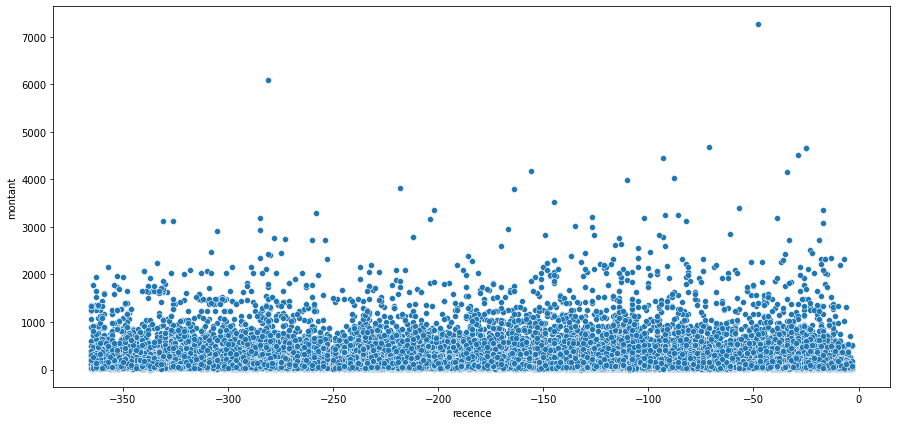

In [56]:
fig = plt.figure(figsize=(15, 7))
sns.scatterplot(x=X_cluster['recence'], y=X_cluster['montant'])
plt.show()

## 3.3 `Normalisation` des variables <a class="anchor" id="setup_4"></a> [⇪](#menu)

En effet, dans la mesure où nous allons utiliser des algorithmes basés sur la distance et ou l'on constate clairement des différences d'échelles, il est préférable de normaliser nos données.

In [57]:
from sklearn.preprocessing import MinMaxScaler  # StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder,

In [58]:
def fit_normalizer(data):
    """ Normalize the values of the provided dataset

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset used as reference for the scaler

    Returns
    -------
    MinMaxScaler
        the scaler instance
    """

    scaler = MinMaxScaler()
    scaler.fit(data)

    return scaler


def normalize(data, scaler):
    """ Transform the provided dataset using the provided scaler.

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset that needs to be scaled
    scaler: MinMaxScaler 
        the scaler instance to apply on the dataset

    Returns
    -------
    DataFrame
        a new dataframe with the scaled values
    """

    dt = data.copy()
    dt = pd.DataFrame(scaler.transform(dt), index=dt.index, columns=dt.columns)

    return dt


def get_inverse_normalization(scaler, data):
    """ Transform the provided dataset using the provided scaler back to the original scales

    Parameters
    ----------
    data: pandas' DataFrame
        the dataset that needs to be scaled
    scaler: MinMaxScaler 
        the scaler instance to apply on the dataset
    columns: list
        the list of columns to consider

    Returns
    -------
    DataFrame
        a new dataframe with the scaled values
    """
    
    return pd.DataFrame(scaler.inverse_transform(data), columns=data.columns)

In [59]:
model_scaler = fit_normalizer(X_cluster)
X_cluster_norm = normalize(X_cluster, model_scaler)

In [60]:
X_cluster_norm.head(2)

,recence,montant,review_score,answer_days,mean_items,total_items
0,0.008287,0.011384,0.875,0.002874,0.0,0.043478
1,0.900552,0.019445,0.750,0.000000,0.0,0.000000


In [61]:
X_cluster_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,73756.0,0.517608,0.274942,0.0,0.276243,0.516575,0.748619,1.0
montant,73756.0,0.023218,0.030423,0.0,0.008797,0.015226,0.025741,1.0
review_score,73756.0,0.783465,0.324573,0.0,0.750000,1.000000,1.000000,1.0
answer_days,73756.0,0.006848,0.020018,0.0,0.000000,0.002874,0.008621,1.0
mean_items,73756.0,0.007565,0.028138,0.0,0.000000,0.000000,0.000000,1.0
total_items,73756.0,0.009570,0.032213,0.0,0.000000,0.000000,0.000000,1.0


## 3.4 Création des fonctions génériques <a class="anchor" id="setup_5"></a> [⇪](#menu)

### Définissons la métrique utilisée par la fonction de recherche des hyper-paramètres

In [62]:
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples

In [63]:
def cv_silhouette_scorer(estimator, X_ref):
    estimator.fit(X_ref)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X_ref.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X_ref, cluster_labels)

### Définissons des fonctions pour afficher et enregistrer les scores

In [64]:
#from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
import matplotlib.cm as cm

In [65]:
def draw_silhouette(fitted_model, X_ref, silhouette_avg=None):

    #fig, (ax1, ax2) = plt.subplots(1, 2)
    #fig.set_size_inches(15, 7)
    fig = plt.figure(figsize=(15, 7))

    if silhouette_avg is None:
        silhouette_avg = cv_silhouette_scorer(fitted_model, X_ref)

    cluster_labels = fitted_model.labels_
    try:
        sample_silhouette_values = silhouette_samples(X_ref, cluster_labels)
    except Exception:
        print("Il n'y a qu'un seul cluster, et silhouette_samples à besoin d'au moins 2 cluster...")
        return

    if hasattr(fitted_model, 'n_clusters'):
        n_clusters = fitted_model.n_clusters
    elif hasattr(fitted_model, 'n_features_in_'):
        # n_clusters = fitted_model.n_features_in_
        n_clusters = pd.DataFrame(cluster_labels).nunique()[0]

    # 1st Plot showing the silhouettes
    ax1 = fig.add_subplot(121)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.cmap_ref(float(i) / n_clusters)
        color = cm.nipy_spectral(float(i) / n_clusters)

        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    if len(X_ref.columns) > 2:
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(
            X_training['recence'], X_training['montant'], X_training['review_score'],
            marker="o", lw=0, alpha=0.7,
            c=colors, edgecolor="k"
        )
        ax2.set_xlabel('recence')
        ax2.set_ylabel('montant')
        ax2.set_zlabel('review score')
        ax2.set_title("The 3D visualization of the clustered data.")
    else:
        ax2 = fig.add_subplot(122)
        ax2.scatter(
            #X_ref.iloc[:, 0], X_ref.iloc[:, 1],
            X_training['recence'], X_training['montant'],
            marker=".", lw=0, alpha=0.7, 
            c=cluster_labels, edgecolor="k", cmap=cmap_ref,
        )
        ax2.set_xlabel('recence')
        ax2.set_ylabel('montant')
        ax2.set_title("The 2D visualization of the clustered data.")

    plt.suptitle(f"Silhouette analysis with n_clusters = {n_clusters}", fontsize=14, fontweight="bold")
    plt.show()

In [66]:
scores_df = pd.DataFrame(columns=['Method', 'params', 'best_params', 'silhouette', 'Training time', 'Inference time'])
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)


def get_clustering_scores(method_name, model, X_ref=None, param_grid=None, best_params=None, training_time=None, inference_time=None, register=False, **others):
    """ Compute / Display / Save scores for the provided model

    More precisely, it compute the scores then call various function to display and save them.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    model: 
        the model that needs to be evaluated
    X_ref: list of lists
        the X values used to get the predictions
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    """

    if X_ref is None:
        X_ref = X_cluster

    silhouette_avg = cv_silhouette_scorer(model, X_ref)
    scores = {'silhouette': silhouette_avg}

    # Register score and replace if it already exists
    if register:
        save_score(method_name, param_grid, best_params, training_time, inference_time, **scores)

    # Basic report
    scores_str = ""
    for key in scores.keys():
        scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"

    print(f"--- {method_name} ---".ljust(100, '-'), "\n\n", scores_str, sep="")

    # Silhouette plot
    # visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
    # visualizer.fit(X_ref)
    # visualizer.show();
    draw_silhouette(model, X_ref, silhouette_avg=silhouette_avg)

In [67]:
def save_score(method_name, param_grid, best_params, training_time, inference_time, **scores):
    """ Save the scores into the 'scores_df' DataFrame and to the 'scores_path' CSV file.
    Each call to this function appends exactly one row to the DataFrame and hence to the CSV.

    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    param_grid: dict
        the parameter grid used to get the provided scores
    best_params: dict
        the best parameters found with the gridsearch
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    scores: list of parameters
        the scores to register
    """

    idx = np.where(scores_df.Method == method_name)[0]
    idx = idx[0] if idx.size > 0 else len(scores_df.index)

    silhouette = scores.get('silhouette', None)

    scores_df.loc[idx] = [method_name, param_grid, best_params, silhouette, training_time, inference_time]
    scores_df.to_csv(scores_path, index=False)

In [68]:
def plot_silhouette(model, data):

    model = model.fit(data)
    score = silhouette_score(data, model.labels_)
    print(f"Silhouette score moyen: {score:.3f}")

    # plt.figure(figsize=(10, 7))
    # visualizer = SilhouetteVisualizer(model, colors='yellowbrick', is_fitted=True)
    # visualizer.fit(data)
    # visualizer.show();
    draw_silhouette(model, data, silhouette_avg=score)

    return model

In [69]:
def get_means(fitted_model, X_cluster):
    X_labels = pd.DataFrame(fitted_model.labels_, columns=['label'])
    X_results = X_cluster.merge(X_labels, left_index=True, right_index=True)

    groups = {}
    for i in range(fitted_model.n_clusters):
        groups[i] = X_results[X_results.label == i].mean()

    return pd.DataFrame.from_dict(groups).T.drop(columns=['label'])

In [70]:
def plot_dendrogram(model, y_cut=0, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    fig = plt.figure(figsize=(15, 7))
    dendrogram(linkage_matrix, **kwargs)
    plt.grid(False)
    if type(y_cut) == list:
        for y_c in y_cut:
            plt.axhline(y=y_c, c='grey', lw=1, linestyle='dashed')
    else:
        plt.axhline(y=y_cut, c='grey', lw=1, linestyle='dashed')
    plt.show()


def plot_dendrogram_full(X_ref):
    linked = linkage(X_ref, 'single')

    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
    plt.show()


---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Comme on a des algorithmes qui utilisent les distances, il est préférable de **normaliser les données** !

---
---
### 🔔 Avant d'aller plus loin, réduisons le jeu de données pour que les algorithmes puissent travailler plus rapidement dans un premier temps

In [71]:
X_training = X_cluster_norm.sample(frac=0.25, random_state=random_seed).reset_index(drop=True).copy()
#X_training = X_cluster_norm.reset_index(drop=True).copy()

---
---
# 7. Modèle final <a class="anchor" id="final"></a> [⇪](#menu)


#### Reprenons le modèle le plus utile que nous avons pu découvrir

Silhouette score moyen: 0.453


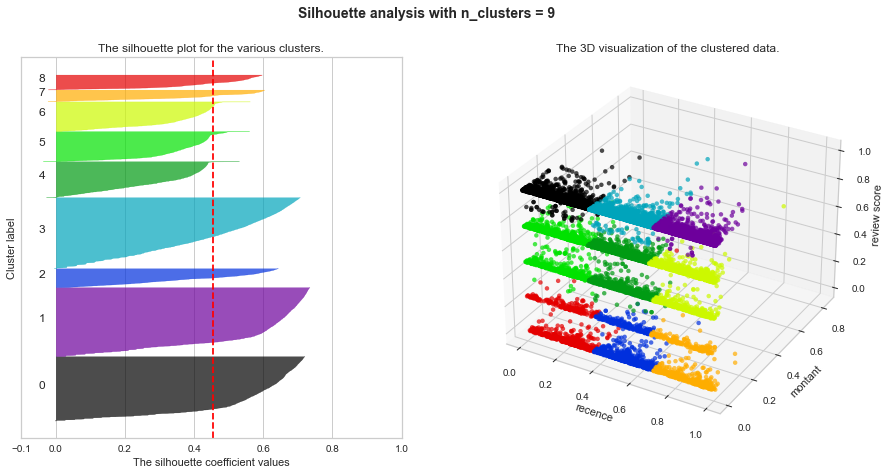

In [136]:
fitted_model = plot_silhouette(KMeans(n_clusters=9, random_state=random_seed), X_training)

#### Affichons les moyennes des variables par cluster *(dans les échelles d'origine)*

In [137]:
get_inverse_normalization(model_scaler, get_means(fitted_model, X_training)).sort_values(['recence'])

,recence,montant,review_score,answer_days,mean_items,total_items
5,-298.380774,170.748533,3.671532,2.463986,1.135074,1.234082
0,-297.591688,167.414002,4.993059,2.651216,1.109789,1.229003
8,-288.948428,197.461660,1.242558,2.274214,1.337526,1.426415
4,-183.283029,163.329196,3.666118,2.655352,1.150870,1.250131
2,-178.585244,190.032293,1.196577,2.164673,1.296278,1.356929
3,-175.994729,159.140327,4.994641,2.291645,1.106528,1.181603
7,-64.943639,180.165330,1.269726,2.427536,1.352657,1.371981
6,-64.519899,159.750600,3.731207,2.289482,1.144978,1.193304
1,-59.743555,165.925216,4.998010,2.087427,1.115332,1.156038


>#### On constate que:
> - les silhouettes montrent quelques points mal classés sur les groupes 4,5 et 8.
> - on a un score honorable de 0.454.

> - `cluster 7`: les clients *insatisfaits* qui ont *dépensé plus que la moyenne* et que l'on a *vu récemment*.
> - `cluster 2`: les clients *insatisfaits* qui ont *dépensé plus que la moyenne* et que l'on a *vu il y a un certain temps*.
> - `cluster 8`: les clients *insatisfaits* qui ont *dépensé plus que la moyenne* et que l'on a *vu il y a longtemps*.
><br><br>
> - `cluster 6`: les clients *modérément satisfaits* qui ont *dépensé moins que la moyenne* et que l'on a *vu récemment*.
> - `cluster 4`: les clients *modérément satisfaits* et que l'on a *vu il y a un certain temps*.
> - `cluster 5`: les clients *modérément satisfaits* et que l'on a *vu il y a longtemps*.
><br><br>
> - `cluster 1`: les clients *satisfaits* et que l'on a *vu récemment*.
> - `cluster 3`: les clients *satisfaits* qui ont *dépensé moins que la moyenne* et que l'on a *vu il y a un certain temps*.
> - `cluster 0`: les clients *satisfaits* et que l'on a *vu il y a longtemps*.
>
> Ce découpage est plutôt intéressant aussi.

#### Affichons un parallel plot des centroids

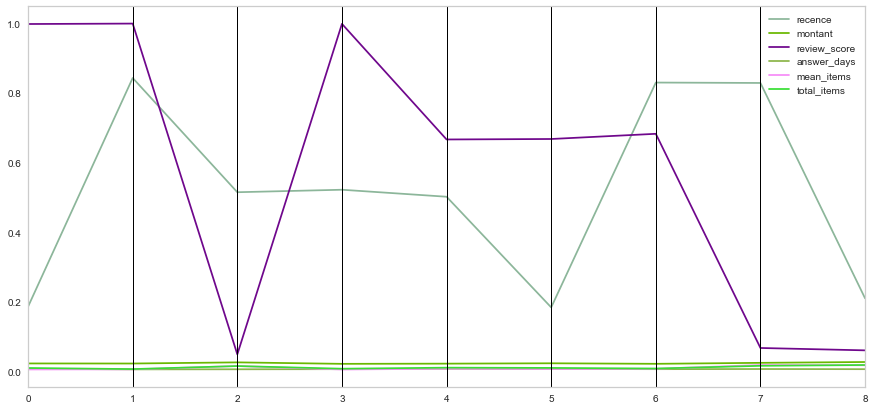

In [152]:
fig = plt.figure(figsize=(15, 7))
centroids = pd.DataFrame(fitted_model.cluster_centers_.T, index=X_training.columns).reset_index()
pd.plotting.parallel_coordinates(centroids, class_column='index')
plt.show()

>#### On constate que sur ce modèle, ce sont principalement la `recence` et le `review_score` qui aident à déterminer les clusters...
>Les autres variables n'ont qu'une influence à la marge.